In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# -------------------------------
# 1. Parameters (customize these)
# -------------------------------

# Soil properties (in mm)
field_capacity = 200   # water at field capacity
wilting_point = 100    # water at wilting point
root_zone_depth = 1.0  # meters

In [19]:
# Crop properties
kc = 1.0  # crop coefficient (can vary by growth stage)

In [20]:
# Irrigation rule: trigger irrigation when soil water < threshold
trigger_fraction = 0.5
irrigation_threshold = wilting_point + (field_capacity - wilting_point) * trigger_fraction


In [21]:
# Irrigation efficiency (e.g., drip: 0.9, sprinkler: 0.7)
irrigation_efficiency = 0.8

In [22]:
# ----------------------------------------
# 2. Sample Data: Daily weather and ET₀
# ----------------------------------------

data = {
    'date': pd.date_range(start='2023-01-01', periods=10, freq='D'),
    'precipitation': [0, 0, 5, 0, 0, 2, 0, 3, 0, 0],     # mm
    'et0': [3.5, 4.0, 4.2, 3.8, 4.1, 4.3, 4.0, 3.9, 4.2, 4.0],  # mm/day
}

df = pd.DataFrame(data)


In [23]:
# ----------------------------------------
# 3. Initialization
# ----------------------------------------

# Assume initial soil moisture at field capacity
df['soil_moisture'] = np.nan
df.loc[0, 'soil_moisture'] = field_capacity

# Compute crop evapotranspiration (ETc)
df['etc'] = df['et0'] * kc

# Storage for outputs
df['irrigation'] = 0.0

In [24]:
# ----------------------------------------
# 4. Daily Simulation Loop
# ----------------------------------------

for i in range(1, len(df)):
    prev_moisture = df.loc[i-1, 'soil_moisture']
    
    # Calculate next day's soil moisture
    inflow = df.loc[i, 'precipitation']
    outflow = df.loc[i, 'etc']
    soil_moisture = prev_moisture + inflow - outflow
    
    # Clip to not exceed field capacity or drop below wilting point
    soil_moisture = max(min(soil_moisture, field_capacity), wilting_point)
    
    # Check if irrigation is needed
    if soil_moisture < irrigation_threshold:
        # Amount of water needed to bring to field capacity
        water_deficit = field_capacity - soil_moisture
        
        # Account for irrigation efficiency
        irrigation = water_deficit / irrigation_efficiency
        
        df.loc[i, 'irrigation'] = irrigation
        
        # Apply irrigation and update soil moisture
        soil_moisture += irrigation * irrigation_efficiency

    # Store updated soil moisture
    df.loc[i, 'soil_moisture'] = soil_moisture

In [25]:
# ----------------------------------------
# 5. Output
# ----------------------------------------

df['cumulative_irrigation'] = df['irrigation'].cumsum()

# Display the results
print(df[['date', 'precipitation', 'et0', 'etc', 'soil_moisture', 'irrigation', 'cumulative_irrigation']])

        date  precipitation  et0  etc  soil_moisture  irrigation  \
0 2023-01-01              0  3.5  3.5          200.0         0.0   
1 2023-01-02              0  4.0  4.0          196.0         0.0   
2 2023-01-03              5  4.2  4.2          196.8         0.0   
3 2023-01-04              0  3.8  3.8          193.0         0.0   
4 2023-01-05              0  4.1  4.1          188.9         0.0   
5 2023-01-06              2  4.3  4.3          186.6         0.0   
6 2023-01-07              0  4.0  4.0          182.6         0.0   
7 2023-01-08              3  3.9  3.9          181.7         0.0   
8 2023-01-09              0  4.2  4.2          177.5         0.0   
9 2023-01-10              0  4.0  4.0          173.5         0.0   

   cumulative_irrigation  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
5                    0.0  
6                    0.0  
7                    0.0  
8       

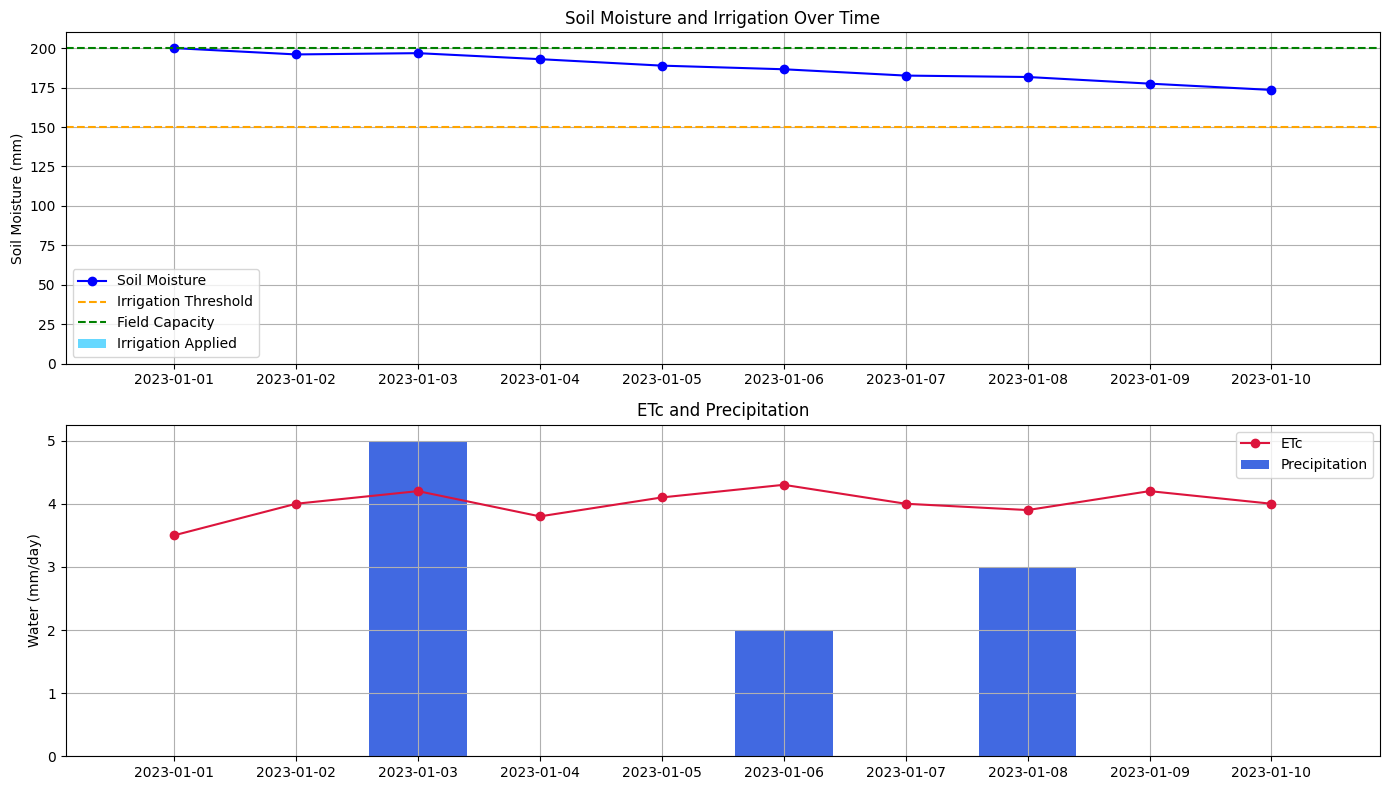

In [26]:
# -------------------------------
# 6. Visualization
# -------------------------------
plt.figure(figsize=(14, 8))

# Soil Moisture and Irrigation
plt.subplot(2, 1, 1)
plt.plot(df['date'], df['soil_moisture'], label='Soil Moisture', color='blue', marker='o')
plt.axhline(irrigation_threshold, color='orange', linestyle='--', label='Irrigation Threshold')
plt.axhline(field_capacity, color='green', linestyle='--', label='Field Capacity')
plt.bar(df['date'], df['irrigation'], width=0.8, label='Irrigation Applied', color='deepskyblue', alpha=0.6)
plt.ylabel('Soil Moisture (mm)')
plt.title('Soil Moisture and Irrigation Over Time')
plt.legend()
plt.grid(True)

# Precipitation and ETc
plt.subplot(2, 1, 2)
plt.bar(df['date'], df['precipitation'], width=0.8, label='Precipitation', color='royalblue')
plt.plot(df['date'], df['etc'], label='ETc', color='crimson', marker='o')
plt.ylabel('Water (mm/day)')
plt.title('ETc and Precipitation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()